# Validating regression models for prediction
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

# Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

# Load and clean data

In [17]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
sns.set()

In [2]:
from clean import clean

c2013_df = clean(pd.read_csv("NYC_2013_crime.csv"))
# 2014 data has an extra column "Unnamed: 13" full of NaNs; we'll drop it.
c2014_df = clean(pd.read_csv("NYC_2014_crime.csv").drop("Unnamed: 13", axis=1))

To confirm that the datasets are similar, I'll print out the percentage change in the statistics for each colummn.

In [3]:
print( (c2013_df.describe() - c2014_df.describe()) / c2013_df.describe() )

       Population  violent_crime    Murder   Robbery  agg_assault  prop_crime  \
count   -0.058309      -0.058309 -0.058309 -0.058309    -0.058309   -0.058309   
mean     0.069012       0.059734  0.065149  0.086991     0.088678    0.149999   
std      0.012731       0.023627  0.111865  0.057528     0.043925    0.054538   
min      0.849810            NaN       NaN       NaN          NaN         NaN   
25%      0.124937       0.500000       NaN       NaN     1.000000    0.371795   
50%      0.095634       0.166667       NaN  0.000000     0.250000    0.324324   
75%      0.142994       0.195122       NaN  0.111111     0.153846    0.229042   
max     -0.004768      -0.013906  0.200000 -0.087719     0.043726    0.049389   

       Burglary   Larceny  mv_theft     Arson  
count -0.058309 -0.058309 -0.058309 -0.058309  
mean   0.196087  0.142460  0.098631 -0.958641  
std    0.132767  0.036730  0.030499 -0.332784  
min         NaN       NaN       NaN       NaN  
25%    0.333333  0.354839     

Looking at the percentage changes in the means of the columns above, we can see that all of these changes look small and feasible exxcept for the 68% drop in arson.  Given the likelihood that this represents a difference in reporting, we'll drop the arson column.  Otherwise, the data all looks similar, so we'll go ahead and combine the two years for a larger dataset.

In [4]:
c2013_df["Year"] = 2013
c2014_df["Year"] = 2014
crime_df = c2013_df.append(c2014_df)
crime_df.drop("Arson", axis=1, inplace=True)
crime_df.sort_values("City").head()

,City,Population,violent_crime,Murder,Robbery,agg_assault,prop_crime,Burglary,Larceny,mv_theft,Year
0,Adams Village,1861,0,0,0,0,12,2,10,0,2013
0,Adams Village,1851,0,0,0,0,11,1,10,0,2014
1,Addison Town and Village,2568,2,0,1,1,49,1,47,1,2014
1,Addison Town and Village,2577,3,0,0,3,24,3,20,1,2013
2,Afton Village4,820,0,0,0,0,1,0,1,0,2014


In [5]:
crime_df[crime_df["Population"]>100000]

,City,Population,violent_crime,Murder,Robbery,agg_assault,prop_crime,Burglary,Larceny,mv_theft,Year
7,Amherst Town,118296,107,1,31,68,2118,204,1882,32,2013
9,Amherst Town4,118860,128,1,43,68,2066,176,1846,44,2014


# Running the model

In my previous model, I predicted violent crime rates from the population and the specific nonviolent crime statistics of burglary, larceny, and motor vehicle theft.  The model yielded an r-score of just over .8, and relied primarily on motor vehicle theft and secondarily on burglary to generate this prediction.

To begin here, I'll run the model as it was.

In [6]:
# randomly select 30% of rows as CV set
from sklearn.model_selection import train_test_split
y = crime_df["violent_crime"]
X_train, X_cv, y_train, y_cv = train_test_split(crime_df[["Population","Burglary","Larceny","mv_theft"]], y, test_size=0.3)

In [7]:
# run the model repeatedly to generate typical outcome regardless of random data division (because dataset is small)
def regtest(crime_df):
    # randomly select 30% of rows as CV
    y = crime_df["violent_crime"]
    X_train, X_cv, y_train, y_cv = train_test_split(crime_df[["Population","Burglary","Larceny","mv_theft"]], y, test_size=0.3)

    from sklearn import linear_model
    rModel = linear_model.LinearRegression(normalize=True)
    rModel.fit(X_train, y_train)
    return rModel.coef_, rModel.score(X_cv, y_cv)

rcoefs = []
rscores = []
for i in range(200):
    coef, score = regtest(crime_df)
    rscores.append(score)
    rcoefs.append(coef)
print(sum(rscores)/len(rscores))
print(sum(rcoefs)/len(rcoefs))

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.8588237901210491
[-2.54968303e-04  5.08205715e-01 -2.64771868e-02  2.39681379e+00]


This R-squared value already represents a roughly .5 improvement on the previous outcomes, simply because I have twice the data to work with.

We can also eliminate the population column, which has the lowest coefficient after normalization, and get basically the same R-value (to three digits):

In [8]:
# run the model repeatedly to generate typical outcome regardless of random data division (because dataset is small)
def regtest(crime_df):
    # randomly select 30% of rows as CV
    y = crime_df["violent_crime"]
    X_train, X_cv, y_train, y_cv = train_test_split(crime_df[["Burglary","Larceny","mv_theft"]], y, test_size=0.3)

    from sklearn import linear_model
    rModel = linear_model.LinearRegression(normalize=True)
    rModel.fit(X_train, y_train)
    return rModel.coef_, rModel.score(X_cv, y_cv)

rcoefs = []
rscores = []
for i in range(200):
    coef, score = regtest(crime_df)
    rscores.append(score)
    rcoefs.append(coef)
print(sum(rscores)/len(rscores))
print(sum(rcoefs)/len(rcoefs))

0.8601260778565865
[ 0.53033391 -0.03749037  2.3397393 ]


# Evaluation

We already have a fairly good R-squared of about 0.86.  Let's make sure our variable relations look linear:

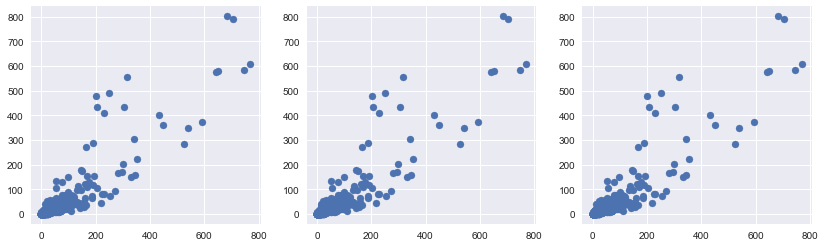

In [18]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.scatter(crime_df["Burglary"], crime_df["violent_crime"])
plt.subplot(132)
plt.scatter(crime_df["Burglary"], crime_df["violent_crime"])

plt.subplot(133)
plt.scatter(crime_df["Burglary"], crime_df["violent_crime"])
plt.show()

So far so good!  Now let's take a look at our residuals:

Built-in R-squared method: 0.8484378280413712
Manual R-squared score: 0.895210436229336
Strangely, these two are always slightly different, with no consistent margin or direction.  Why???


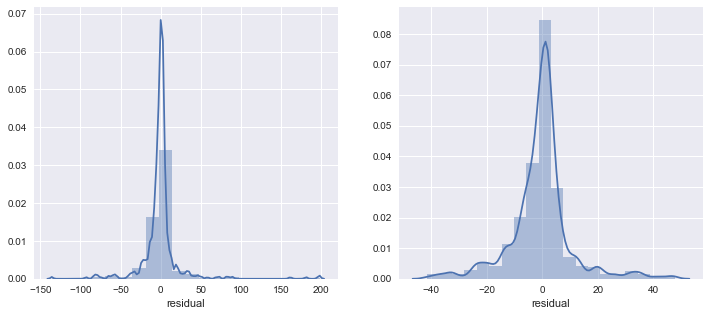

F_onewayResult(statistic=2.0204263562078342e-31, pvalue=1.0)


In [32]:
y = crime_df["violent_crime"]
X_train, X_cv, y_train, y_cv = train_test_split(crime_df[["Burglary","Larceny","mv_theft"]], y, test_size=0.3)

from sklearn import linear_model
rModel = linear_model.LinearRegression(normalize=True)
rModel.fit(X_train, y_train)

cv_df = pd.DataFrame(X_train)
cv_df["violent_crime"] = y_train
cv_df["predicted_vc"] = rModel.intercept_ + rModel.coef_[0]*cv_df["Burglary"] + rModel.coef_[1]*cv_df["Larceny"] + rModel.coef_[2]*cv_df["mv_theft"]
cv_df["residual"] = cv_df["violent_crime"] - cv_df["predicted_vc"]

import scipy as sp
print("Built-in R-squared method: " + str(rModel.score(X_cv, y_cv)))
print("Manual R-squared score: " + str(sp.stats.pearsonr(cv_df["violent_crime"], cv_df["predicted_vc"])[0]**2))
print("Strangely, these two are always slightly different, with no consistent margin or direction.  Why???")

plt.figure(figsize=(12,5))
plt.xlabel("All residual value counts")
plt.subplot(121)
sns.distplot(cv_df["residual"], bins=20)
plt.subplot(122)
plt.xlabel("Residual value counts abs < 50")
sns.distplot(cv_df[abs(cv_df["residual"])<50]["residual"], bins=20)
plt.show()

import scipy.stats as stats
print(stats.f_oneway(cv_df["predicted_vc"], cv_df["violent_crime"]))

The residuals look pretty normally distributed, aside from a few outliers – another good sign.  How about the residuals vs y-values?  (i.e., checking for heteroscedacicity)

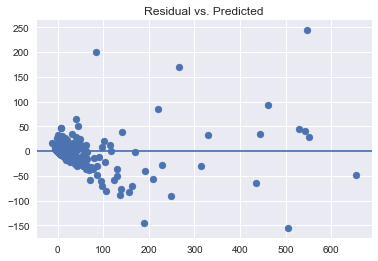

In [21]:
plt.scatter(cv_df["predicted_vc"], cv_df["residual"])
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

We definitely see some heteroscedasticity here - which is also evident in the scatterplots of the original data above.  There are larger residuals for the larger cities with more crime.  For small cities, the errors are all small.  This heteroscedasticity is intrinsic to the data and isn't stopping us from getting a good R-squared value, so we needn't overhaul the model just because of it.

Overall, this is a pretty effective model.